# Image Captioning

## Data processing

In [1]:
from pathlib import Path
import torch

import numpy as np
import matplotlib.pyplot as plt

from torchvision.transforms import Resize, ToTensor, RandomRotation, Normalize

import torch.nn as nn
from torch import optim

from datetime import datetime as dt

The file captions.txt is a txt file where each row presents an image_name, the comment_number and the comment, since each image has 5 different captions

In [2]:
import os
import pandas as pd
import zipfile

zip_file_path = "./archive.zip"
extract_folder = "./archive"

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_folder)

images_path = os.path.join(extract_folder, "flickr30k_images")
captions_path = "./captions.txt"

archive_df = pd.read_csv(
    captions_path,
    sep=",",
    header=None,
    names=["image_name", "caption_id", "caption"],
    skiprows=1,
)

"""
captions_df['image_path'] = captions_df['image_name'].apply(lambda x: os.path.join(images_path, x))
final_dataset = captions_df[['image_name', 'caption']]
final_dataset.to_csv('expanded_final_dataset.csv', index=False)
print(final_dataset.head)
"""

"\ncaptions_df['image_path'] = captions_df['image_name'].apply(lambda x: os.path.join(images_path, x))\nfinal_dataset = captions_df[['image_name', 'caption']]\nfinal_dataset.to_csv('expanded_final_dataset.csv', index=False)\nprint(final_dataset.head)\n"

## Vocabulary of words

In [3]:
!pip install nltk

In [4]:
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("punkt_tab")


class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {}
        self.idx2word = {}
        self.wheights = {}
        self.idx = 0

        self.add_word("<PAD>")  # to have all sentences of same target_len
        self.add_word("<SOS>")
        self.add_word("<EOS>")
        self.add_word("<UNK>")  # unknown word

        self.counter = None

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        for sentence in sentence_list:
            sentence = self.preprocess(sentence)
            words = word_tokenize(sentence.lower())
            frequencies.update(words)
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.add_word(word)
                self.wheights[word] = 1 / freq

        self.counter = frequencies

    def numericalize(self, sentence):
        sentence = self.preprocess(sentence)
        tokenized_text = word_tokenize(sentence.lower())
        return [
            self.word2idx.get(word, self.word2idx["<UNK>"]) for word in tokenized_text
        ]

    def one_hot_encode(self, word_or_idx):
        if isinstance(word_or_idx, str):  # If it's a word
            idx = self.word2idx.get(word_or_idx, self.word2idx["<UNK>"])
        elif isinstance(word_or_idx, int):  # If it's already an index
            idx = word_or_idx
        else:
            raise ValueError("Input must be a word (str) or an index (int).")
        one_hot_vector = torch.zeros(len(self.word2idx), dtype=torch.float32)
        one_hot_vector[idx] = 1.0
        return one_hot_vector

    def one_hot_encode_caption(self, caption):
        one_hot_vectors = [self.one_hot_encode(word) for word in caption]
        return torch.tensor(one_hot_vectors)

    def preprocess(self, sentence):
        return "".join([char for char in sentence if char.isalnum() or char.isspace()])

    def __len__(self):
        return len(self.word2idx)


# Probably captions need to be stored like this...


def caption_to_indices(vocab, caption):
    indices = [vocab.word2idx["<SOS>"]]
    for word in caption.split():
        indices.append(vocab.word2idx.get(word.lower(), "<UNK>"))
    indices.append(vocab.word2idx["<EOS>"])
    return indices


def pad_sequence(seq, target_len, pad_idx):
    if len(seq) < target_len:
        seq.extend(
            [pad_idx] * (target_len - len(seq))
        )  # padding at the end of sequence
    return seq[:target_len]


# caption_indices_list = [caption_to_indices(our_vocab, caption) for caption in captions_list]
# pad_idx = our_vocab.word2idx['<PAD>']
# caption_indices_padded = [pad_sequence(indices, target_len, pad_idx) for indices in caption_indices_list]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Example of usage of nltk and Vocabulary class

In [5]:
# how nltk works

sentence = "NLTK is a great toolkit for text processing!"
words = word_tokenize(sentence)
print(words)


# how a vocab works

example_captions = ["A man was riding a bike.", "A child is drawing a black horse."]

example_vocab = Vocabulary(freq_threshold=1)
example_vocab.build_vocabulary(example_captions)

print("Word -> Index:", example_vocab.word2idx)
print("Index -> Word:", example_vocab.idx2word)

caption = "A child is riding a horse"
numericalized_caption = example_vocab.numericalize(caption)
print("Numeric caption:", numericalized_caption)


['NLTK', 'is', 'a', 'great', 'toolkit', 'for', 'text', 'processing', '!']
Word -> Index: {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'a': 4, 'man': 5, 'was': 6, 'riding': 7, 'bike': 8, 'child': 9, 'is': 10, 'drawing': 11, 'black': 12, 'horse': 13}
Index -> Word: {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'a', 5: 'man', 6: 'was', 7: 'riding', 8: 'bike', 9: 'child', 10: 'is', 11: 'drawing', 12: 'black', 13: 'horse'}
Numeric caption: [4, 9, 10, 7, 4, 13]


Now we will build our own vocabulary using all the captions from the dataset

In [6]:
captions_list = archive_df["caption"].tolist()
if os.path.isfile("our_vocab.pkl"):
    our_vocab = torch.load("our_vocab.pkl")
else:
    our_vocab = Vocabulary(freq_threshold=10)
    our_vocab.build_vocabulary(captions_list)
vocab_size = len(our_vocab)
print("Length of the vocabulary is: ", vocab_size)

Length of the vocabulary is:  5464


In [7]:
words_in_vocab = set(our_vocab.word2idx.keys())
words_in_wheights = set(our_vocab.wheights.keys())
unwheighted_words = words_in_vocab - words_in_wheights
print("Words without wheights: ", unwheighted_words)

our_vocab.wheights["<PAD>"] = 0
our_vocab.wheights["<SOS>"] = 0
our_vocab.wheights["<EOS>"] = 1 / len(our_vocab)
our_vocab.wheights["<UNK>"] = 1 / len(our_vocab)

class_weights = torch.tensor(
    [our_vocab.wheights[our_vocab.idx2word[i]] for i in range(len(our_vocab))]
)

print("Class wheights: ", class_weights[:30])

Words without wheights:  set()
Class wheights:  tensor([0.0000e+00, 0.0000e+00, 1.8302e-04, 1.8302e-04, 4.6206e-05, 7.5654e-05,
        1.5198e-03, 2.7619e-05, 1.9608e-02, 4.5025e-04, 7.5301e-04, 6.1504e-05,
        2.4771e-04, 6.4267e-04, 8.5390e-05, 1.5106e-03, 2.9138e-04, 1.1981e-05,
        1.5878e-05, 2.5381e-03, 7.5884e-05, 4.0323e-03, 4.9515e-05, 2.1268e-04,
        3.3156e-04, 7.7519e-04, 1.0526e-02, 1.0529e-04, 1.9153e-04, 1.0616e-03])


We now define the maximum length an output caption could be

In [8]:
max_caption_length = max([len(caption.split()) for caption in captions_list])
target_len = 15
print("The maximum length a caption produced by our model could reach is ", target_len)

"""
#To find which caption has max length
lengths = np.array([len(caption.split()) for caption in captions_list])
max_length_idx = np.argmax(lengths)
max_caption = captions_list[max_length_idx]
print(max_caption)
print("Number of words:", lengths[max_length_idx])
"""

The maximum length a caption produced by our model could reach is  15


'\n#To find which caption has max length\nlengths = np.array([len(caption.split()) for caption in captions_list])\nmax_length_idx = np.argmax(lengths)\nmax_caption = captions_list[max_length_idx]\nprint(max_caption)\nprint("Number of words:", lengths[max_length_idx])\n'

Convert captions to vectors of indexes

In [9]:
def caption_to_padded_indices(vocab, caption, target_len):
    indices = []  # [vocab.word2idx["<SOS>"]]

    for word in caption.split():
        indices.append(vocab.word2idx.get(word.lower(), vocab.word2idx["<UNK>"]))

    pad_idx = vocab.word2idx["<PAD>"]
    if len(indices) < target_len:
        indices.extend([pad_idx] * (target_len - len(indices)))
    else:
        indices = indices[: (target_len - 1)]
    indices.append(vocab.word2idx["<EOS>"])
    return torch.tensor(indices)


# caption_indices_padded = [
#     caption_to_padded_indices(our_vocab, caption, target_len)
#     for caption in captions_list
# ]

# print(captions_list[0])
# print(caption_indices_padded[0])
# print(caption_indices_padded[0].shape)

print(caption_to_padded_indices(our_vocab, "two men are standing", target_len))

tensor([ 4, 27, 22, 30,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])


In [10]:
def caption_to_one_hot_matrix(vocab, caption, target_len):
    """
    Convert a caption (string) to a one-hot encoded matrix.

    Args:
    - vocab (Vocabulary): The vocabulary object.
    - caption (str): The caption string.
    - target_len (int): The target length for padding the sequence.

    Returns:
    - torch.Tensor: A matrix of shape (target_len, vocab_size) where each row is a one-hot encoded vector.
    """
    words = caption.split()
    indices = [vocab.word2idx["<SOS>"]]
    for word in words:
        idx = vocab.word2idx.get(word.lower(), vocab.word2idx["<UNK>"])
        indices.append(idx)
    indices.append(vocab.word2idx["<EOS>"])
    pad_idx = vocab.word2idx["<PAD>"]
    if len(indices) < target_len:
        indices.extend([pad_idx] * (target_len - len(indices)))
    else:
        indices = indices[:target_len]

    one_hot_matrix = torch.zeros((target_len, len(vocab.word2idx)), dtype=torch.float32)
    for i, idx in enumerate(indices):
        one_hot_matrix[i, idx] = 1.0

    return one_hot_matrix


print(captions_list[0])
print(caption_to_one_hot_matrix(our_vocab, captions_list[0], target_len).shape)


Two young guys with shaggy hair look at their hands while hanging out in the yard .
torch.Size([15, 5464])


## Division into training, validation and test set

Since the pictures repeat themselves with different captions, we need to make sure that in the train, validation and test sets there are different images regardless, otherwise validation and testing wouldn't be done on new and unseen data.

In [11]:
from torch.utils.data import random_split

image_capidx_df = pd.DataFrame(
    {
        "image_name": archive_df["image_name"],
        "caption": archive_df["caption"],
    }
)
print(image_capidx_df.head)

unique_images = image_capidx_df["image_name"].unique()
num_images = len(unique_images)
unique_images_df = pd.DataFrame(unique_images, columns=["image_name"])

np.random.seed(42)  # for reproducibility
np.random.shuffle(unique_images)

train_images, val_images, test_images = random_split(range(num_images), [0.7, 0.2, 0.1])

train_image_names = unique_images_df.iloc[train_images.indices].image_name.tolist()
val_image_names = unique_images_df.iloc[val_images.indices].image_name.tolist()
test_image_names = unique_images_df.iloc[test_images.indices].image_name.tolist()

train_df = image_capidx_df[
    image_capidx_df["image_name"].isin(train_image_names)
].reset_index(drop=True)

val_df = (
    image_capidx_df[image_capidx_df["image_name"].isin(val_image_names)]
    .groupby("image_name", as_index=False)
    .agg({"caption": lambda x: x.sample(1).values[0]})  # Randomly select one caption
).reset_index(drop=True)

test_df = (
    image_capidx_df[image_capidx_df["image_name"].isin(test_image_names)]
    .groupby("image_name", as_index=False)
    .agg({"caption": lambda x: x.sample(1).values[0]})  # Randomly select one caption
).reset_index(drop=True)

print(f"Train dataset size:\t {train_df.shape[0]}")
print(f"Validation dataset size: {val_df.shape[0]}")  # only contains unique images
print(f"Test dataset size:\t {test_df.shape[0]}")  # only contains unique images

<bound method NDFrame.head of             image_name                                            caption
0       1000092795.jpg  Two young guys with shaggy hair look at their ...
1       1000092795.jpg  Two young  White males are outside near many b...
2       1000092795.jpg   Two men in green shirts are standing in a yard .
3       1000092795.jpg       A man in a blue shirt standing in a garden .
4       1000092795.jpg            Two friends enjoy time spent together .
...                ...                                                ...
158910   998845445.jpg  A man in shorts and a Hawaiian shirt leans ove...
158911   998845445.jpg  A young man hanging over the side of a boat  w...
158912   998845445.jpg  A man is leaning off of the side of a blue and...
158913   998845445.jpg  A man riding a small boat in a harbor  with fo...
158914   998845445.jpg  A man on a moored blue and white boat with hil...

[158915 rows x 2 columns]>
Train dataset size:	 111245
Validation dataset size: 6

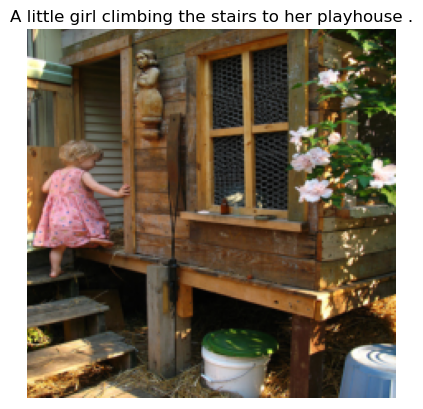

In [12]:
from itertools import chain

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Flickr30kImages(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iloc[idx]["image_name"]
        caption = self.dataframe.iloc[idx]["caption"]
        tensor_captioning_indices = caption_to_padded_indices(
            our_vocab, caption, target_len
        )

        image_path = os.path.join(images_path, image_name)
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, tensor_captioning_indices

    def get_caption(self, idx):
        return self.dataframe.iloc[idx]["caption"]


transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train_dataset = Flickr30kImages(dataframe=train_df, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)


def display_image(index, dataset):
    if index >= len(dataset):
        raise ValueError(f"Index is out of bounds for the dataset")
    image, _ = dataset[index]
    image = image.permute(1, 2, 0).detach().numpy()
    # image = (image * 255).astype('uint8')
    height, width, _ = image.shape
    plt.xlim(0, width)
    plt.ylim(height, 0)
    plt.imshow(image)
    plt.title(dataset.get_caption(index))
    plt.axis("off")
    plt.show()


display_image(2, train_dataset)

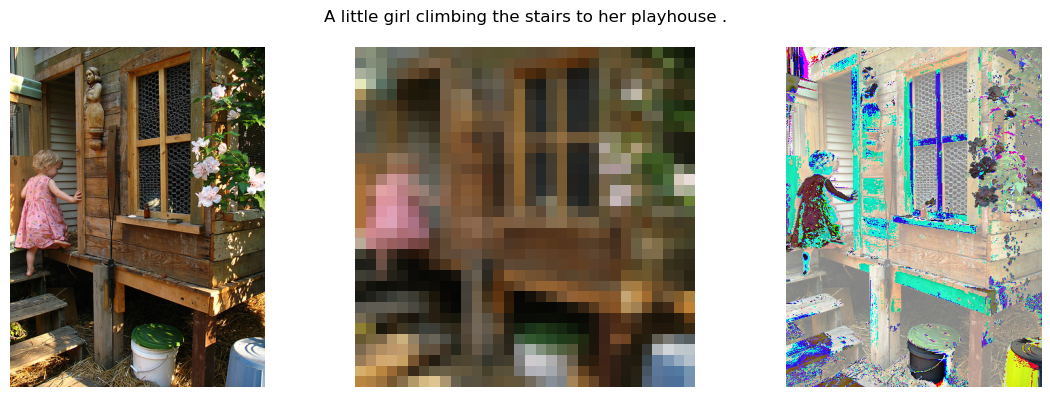

In [13]:
def compare_transforms(transformations, index_image, vocab):
    if not all(isinstance(transf, Dataset) for transf in transformations):
        raise TypeError(
            "All elements in the `transformations` list need to be of type Dataset"
        )

    num_tr = len(transformations)
    fig, axes = plt.subplots(1, num_tr, figsize=(num_tr * 4, 4))

    if num_tr == 1:
        axes = [axes]

    image, _ = transformations[0][index_image]

    for counter, (axis, transf) in enumerate(zip(axes, transformations)):
        image, _ = transf[index_image]
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).detach().numpy()
            if image.shape[2] == 3:
                if image.max() <= 1.0:
                    image = (image * 255).astype("uint8")
        axis.imshow(image)
        axis.axis("off")

    plt.suptitle(transformations[0].get_caption(index_image))
    plt.tight_layout()
    plt.show()


example_dataset1 = Flickr30kImages(train_df)
img_size = 32
transform = transforms.Compose([Resize(size=(img_size, img_size)), ToTensor()])
example_dataset2 = Flickr30kImages(train_df, transform)
transform = transforms.Compose([ToTensor(), Normalize(0.5, 1, inplace=True)])
example_dataset3 = Flickr30kImages(train_df, transform)

ex_dataset = [example_dataset1, example_dataset2, example_dataset3]
compare_transforms(ex_dataset, 2, our_vocab)

In [14]:
example_dataset1[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
 tensor([31, 66, 17, 31, 67, 68, 69, 70, 50, 31, 71, 54, 72, 17, 73]))

## NN model

In [15]:
from torchvision import models
from torchvision.transforms import Resize, ToTensor, Normalize


class NN_conv_gru(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, target_len):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.target_len = target_len

        self.vgg_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        feature_dim = self.vgg_model.classifier[0].in_features
        self.vgg_model.classifier = nn.Identity()

        for param in self.vgg_model.parameters():
            param.requires_grad = False

        self.fc_between1 = nn.Linear(feature_dim, feature_dim // 4)  # to adapt to gru
        self.fc_between2 = nn.Linear(feature_dim // 4, hidden_size)  # to adapt to gru

        self.GRU = nn.GRUCell(input_size, hidden_size, bias=True, dtype=torch.float32)
        self.h_to_words = nn.Linear(hidden_size, output_size)

        self.log_softmax = nn.LogSoftmax(dim=1)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward_cnn(self, input_batch):
        x = self.vgg_model(input_batch)
        return x.squeeze()

    def forward_gru(self, x, h):
        h = self.GRU(x, h)
        y = self.h_to_words(h)
        return y, h

    # not sure of it, to be revised
    def forward(self, input):
        x = self.forward_cnn(input)
        h = self.fc_between1(x)
        h = self.fc_between2(h)
        num_batches = input.shape[0]

        y = torch.zeros((num_batches, self.target_len + 1, self.output_size))
        y[:, 0, :] = our_vocab.one_hot_encode("<SOS>")
        y = y.to(x.device)

        for t in range(self.target_len):
            temp_y = y[:, t, :].clone()
            temp_output, h = self.forward_gru(temp_y, h)
            y = y.clone()
            y[:, t + 1, :] = temp_output
        y = y[:, 1:, :]  # remove the SOS token
        return y

## Training

In [16]:
def training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every
):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss = train_epoch(
            model, optimizer, loss_fn, train_loader, val_loader, device, print_every
        )
        val_loss = validate(model, loss_fn, val_loader, device)
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
            f"Val. loss: {val_loss:.3f}, "
        )
        train_losses.extend(train_loss)
        val_losses.append(val_loss)
    return model, train_losses, val_losses


def train_epoch(
    model, optimizer, loss_fn, train_loader, val_loader, device, print_every
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    train_loss_batches = []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        try:
            inputs, targets = x, y
        except ValueError:
            raise ValueError("train_loader should return a tuple (inputs, targets).")
        inputs, target = x.to(device), y.to(device)
        optimizer.zero_grad()
        torch.autograd.set_detect_anomaly(True)

        logits = model.forward(inputs)
        logits = logits.reshape(-1, logits.size(-1))
        targets = targets.reshape(-1)

        logits = logits.to(device)
        targets = targets.to(device)

        loss = loss_fn(logits, targets)
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        if batch_index % 25 == 0 or batch_index == 1:
            print(f"Batch {batch_index} at time {dt.now()}, loss: {loss.item()}")

        if print_every is not None and batch_index % print_every == 0:
            val_loss = validate(model, loss_fn, val_loader, device)
            model.train()
            print(
                f"\tBatch {batch_index}/{num_batches}: "
                f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                f"\tVal. loss: {val_loss:.3f}, "
            )

    return model, train_loss_batches


def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, targets = x.to(device), y.to(device)
            logits = model.forward(inputs)
            logits = logits.reshape(-1, logits.size(-1))
            targets = targets.reshape(-1)
            batch_loss = loss_fn(logits, targets)
            val_loss_cum += batch_loss.item()
    return val_loss_cum / len(val_loader)

In [18]:
input_size = len(our_vocab.word2idx)
hidden_size = 512
output_size = input_size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = NN_conv_gru(input_size, hidden_size, output_size, target_len)
learning_rate = 0.0000005
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
num_epochs = 1
batch_size = 128


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose(
    [Resize((224, 224)), ToTensor(), Normalize(mean, std, inplace=True)]
)

train_dataset = Flickr30kImages(dataframe=train_df, transform=transform)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
val_dataset = Flickr30kImages(dataframe=val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)

print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
torch.cuda.empty_cache()

checkpoint = torch.load("VGG-GRU-model_v7.ckpt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
del checkpoint

if False:
    model, train_losses, val_losses = training_loop(
        model,
        optimizer,
        loss_fn,
        train_loader,
        val_loader,
        num_epochs,
        print_every=len(train_loader) // 3,
    )

    time = dt.now().strftime("%Y-%m-%d__%H:%M:%S")
    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses,
        },
        f"./CNN-GRU-model_{time}.ckpt",
    )

Training batches: 870, Validation batches: 50


In [26]:
def logits_to_captions(logits, vocab):
    if len(logits.shape) == 2:
        _, predicted_indices = logits.max(dim=-1)
    else:
        predicted_indices = logits
    caption = []
    for idx in predicted_indices:
        word = vocab.idx2word[idx.item()]
        if word == "<EOS>":
            break
        if word != "<SOS>":
            caption.append(word)
    caption_string = " ".join(caption)
    return caption_string


from torchvision.transforms import Resize, ToTensor, Normalize, GaussianBlur

transform_blur = transforms.Compose(
    [
        GaussianBlur(kernel_size=31, sigma=3),
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean, std, inplace=True),
    ]
)
val_dataset = Flickr30kImages(dataframe=test_df, transform=transform_blur)
val_dataset = Flickr30kImages_names(dataframe=test_df, transform=transform_blur)

val_loader = DataLoader(val_dataset, batch_size=3, num_workers=0)
print("Starting validation loop")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
with torch.no_grad():
    for x, y in val_loader:
        # x = add_patches_to_batch(x, 100,4)
        logits = model.forward(x.to(device))
        for batch_idx in range(logits.size(0)):
            print(
                logits_to_captions(logits[batch_idx, :, :], our_vocab),
                " ||| ",
                y[batch_idx],
                # logits_to_captions(y[batch_idx, :], our_vocab),
            )

Starting validation loop
cpu
here golfer golfer no across <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>  |||  1000092795.jpg
you skateboarders clad performing show <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>  |||  1000523639.jpg
this single carries running flowered shirt <UNK> <UNK>  |||  10010052.jpg
closeup golden tries runs through <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>  |||  1001773457.jpg
here baker works white apron apron <UNK> <UNK> <UNK> <UNK>  |||  1010087179.jpg
there motorcyclists walks running running <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>  |||  101093029.jpg
closeup teen checks pours <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>  |||  1014609273.jpg
uniformed uniformed officer headphones <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>  |||  1016626169.jpg
german german chases running running running <UNK> <UNK>  |||  1019077836.jpg
there elderly dressed dressed attire <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>  |||  10

KeyboardInterrupt: 

In [21]:
class Flickr30kImages_names(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iloc[idx]["image_name"]
        caption = self.dataframe.iloc[idx]["caption"]
        tensor_captioning_indices = caption_to_padded_indices(
            our_vocab, caption, target_len
        )

        image_path = os.path.join(images_path, image_name)
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, image_name

    def get_caption(self, idx):
        return self.dataframe.iloc[idx]["caption"]

    def get_image_name(self, idx):
        return self.dataframe.iloc[idx]["image_name"]

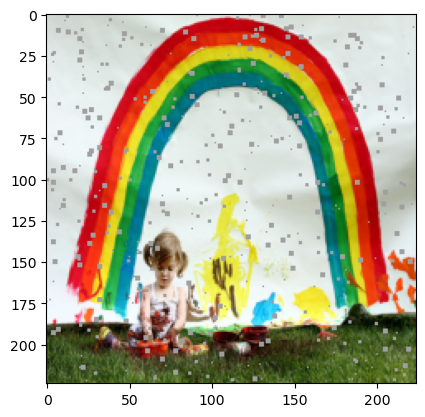

In [116]:
def add_patches_to_batch(batch, num_patches, max_patch_size):
    batch_size, channels, height, width = batch.shape
    for b in range(batch_size):
        picture_mean = batch[b].mean()
        for _ in range(num_patches):
            patch_size = np.random.randint(1, max_patch_size)
            x = np.random.randint(0, width - patch_size)
            y = np.random.randint(0, height - patch_size)
            batch[b, :, y : y + patch_size, x : x + patch_size] = picture_mean
    return batch


jb_transform = transforms.Compose([Resize((224, 224)), ToTensor()])
jb_dataset = Flickr30kImages_names(dataframe=test_df, transform=jb_transform)
hej = jb_dataset[3]
hej = hej[0].unsqueeze(0)
hej = add_patches_to_batch(hej, 400, 4)
plt.imshow(hej[0].permute(1, 2, 0).detach().numpy())


In [27]:
if True:
    test_dataset = Flickr30kImages_names(dataframe=test_df, transform=transform_blur)
    test_loader = DataLoader(val_dataset, batch_size=32, num_workers=0)

    print(f"Starting testing loop with {len(test_loader)} batches")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    test_predicted_dict = {}
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            print(f"Batch {i+1}/{len(test_loader)}")

            logits = model.forward(x.to(device)).cpu()
            for batch_idx in range(logits.size(0)):
                generated_caption = logits_to_captions(
                    logits[batch_idx, :, :], our_vocab
                )
                image_name = y[batch_idx]
                test_predicted_dict[image_name] = generated_caption

    torch.save(test_predicted_dict, "test_predicted_dict_blurred.pkl")
else:
    test_predicted_dict = torch.load("test_predicted_dict_GRU.pkl")

Starting testing loop with 100 batches
cpu
Batch 1/100
Batch 2/100
Batch 3/100
Batch 4/100
Batch 5/100
Batch 6/100
Batch 7/100
Batch 8/100
Batch 9/100
Batch 10/100
Batch 11/100
Batch 12/100
Batch 13/100
Batch 14/100
Batch 15/100
Batch 16/100
Batch 17/100
Batch 18/100
Batch 19/100
Batch 20/100
Batch 21/100
Batch 22/100
Batch 23/100
Batch 24/100
Batch 25/100
Batch 26/100
Batch 27/100
Batch 28/100
Batch 29/100
Batch 30/100
Batch 31/100
Batch 32/100
Batch 33/100
Batch 34/100
Batch 35/100
Batch 36/100
Batch 37/100
Batch 38/100
Batch 39/100
Batch 40/100
Batch 41/100
Batch 42/100
Batch 43/100
Batch 44/100
Batch 45/100
Batch 46/100
Batch 47/100
Batch 48/100
Batch 49/100
Batch 50/100
Batch 51/100
Batch 52/100
Batch 53/100
Batch 54/100
Batch 55/100
Batch 56/100
Batch 57/100
Batch 58/100
Batch 59/100
Batch 60/100
Batch 61/100
Batch 62/100
Batch 63/100


KeyboardInterrupt: 

In [126]:
# test_predicted_dict = imgname -> caption
# filtered_ground_truth_dict = imgname -> [caption]

if False:
    test_ground_truth_dict = {}
    for img_name in test_predicted_dict.keys():
        captions_list = image_capidx_df[image_capidx_df["image_name"] == img_name][
            "caption"
        ].tolist()
        test_ground_truth_dict[img_name] = []

        for caption in captions_list:
            capt = caption.split(" ")
            if not len(capt) <= target_len - 1:  # -1 because of <EOS>
                capt = capt[:target_len]
            test_ground_truth_dict[img_name].append(" ".join(capt))

    torch.save(test_ground_truth_dict, "test_ground_truth_dict.pkl")
else:
    test_ground_truth_dict = torch.load("test_ground_truth_dict.pkl")

In [127]:
from pycocoevalcap.cider.cider import Cider

cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(test_ground_truth_dict, test_predicted_dict)
print(f"CIDEr score for test dataset: {cider_score}")

CIDEr score for test dataset: 0.07245224784931084


In [128]:
#!pip install evaluate

import evaluate

meteor = evaluate.load("meteor")

predictions = [test_predicted_dict[img_name][0] for img_name in test_predicted_dict]
references = [
    test_ground_truth_dict[img_name][0] for img_name in test_ground_truth_dict
]

meteor_score = meteor.compute(predictions=predictions, references=references)

print(f"METEOR score: {meteor_score['meteor']}")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR score: 0.041252543820654186


In [129]:
#!pip install rouge_score

from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

rouge_1_scores = []
rouge_2_scores = []
rouge_l_scores = []

for image_name in test_predicted_dict.keys():
    references = test_ground_truth_dict[image_name]
    prediction = test_predicted_dict[image_name][0]
    scores = scorer.score(references[0], prediction)
    rouge_1_scores.append(scores["rouge1"].fmeasure)
    rouge_2_scores.append(scores["rouge2"].fmeasure)
    rouge_l_scores.append(scores["rougeL"].fmeasure)

average_rouge_1 = sum(rouge_1_scores) / len(rouge_1_scores)
average_rouge_2 = sum(rouge_2_scores) / len(rouge_2_scores)
average_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores)

print(f"Average ROUGE-1 Score: {average_rouge_1}")
print(f"Average ROUGE-2 Score: {average_rouge_2}")
print(f"Average ROUGE-L Score: {average_rouge_l}")


Average ROUGE-1 Score: 0.0746393472890739
Average ROUGE-2 Score: 0.004331233616033031
Average ROUGE-L Score: 0.07184172958961231


5464